## 範例重點
* 學習如何在 keras 中撰寫自定義的 loss function
* 知道如何在訓練時使用自定義的 loss function

In [2]:
import os
import keras
import numpy as np


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

## Work
1. 自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [16]:
import tensorflow as tf
import tensorflow.keras.backend as K

def combined_loss(ce_w, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
        
    def combined_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        
        reduced_ce = tf.reduce_max(ce, axis=1)
        reduced_fl = tf.reduce_max(fl, axis=1)
            
        return (1-ce_w) * tf.reduce_mean(reduced_fl) + ce_w * tf.reduce_mean(reduced_ce)

    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [17]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (

50000/50000 [==============================] - 10s 200us/step - loss: 0.1503 - accuracy: 0.9808 - val_loss: 6.0009 - val_accuracy: 0.4862
Epoch 46/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.1377 - accuracy: 0.9843 - val_loss: 6.2113 - val_accuracy: 0.4676
Epoch 47/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.1248 - accuracy: 0.9864 - val_loss: 6.0896 - val_accuracy: 0.4879
Epoch 48/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.1124 - accuracy: 0.9886 - val_loss: 6.2145 - val_accuracy: 0.4808
Epoch 49/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.1029 - accuracy: 0.9898 - val_loss: 6.3191 - val_accuracy: 0.4884
Epoch 50/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.0930 - accuracy: 0.9914 - val_loss: 6.2541 - val_accuracy: 0.4786
Numbers of exp: 1, ce_weight: 0.30
Model: "model_7"
____________________________________________________________

Epoch 40/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.3426 - accuracy: 0.9433 - val_loss: 4.5815 - val_accuracy: 0.4728
Epoch 41/50
50000/50000 [==============================] - 10s 201us/step - loss: 0.3205 - accuracy: 0.9476 - val_loss: 4.7072 - val_accuracy: 0.4789
Epoch 42/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.2986 - accuracy: 0.9521 - val_loss: 4.5826 - val_accuracy: 0.4815
Epoch 43/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.2706 - accuracy: 0.9600 - val_loss: 4.7222 - val_accuracy: 0.4712
Epoch 44/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.2530 - accuracy: 0.9637 - val_loss: 4.7787 - val_accuracy: 0.4791
Epoch 45/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.2333 - accuracy: 0.9677 - val_loss: 4.7468 - val_accuracy: 0.4809
Epoch 46/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.2151 - accuracy:

50000/50000 [==============================] - 12s 241us/step - loss: 0.6272 - accuracy: 0.8727 - val_loss: 3.3865 - val_accuracy: 0.4811
Epoch 35/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.5882 - accuracy: 0.8816 - val_loss: 3.4432 - val_accuracy: 0.4753
Epoch 36/50
50000/50000 [==============================] - 12s 247us/step - loss: 0.5543 - accuracy: 0.8908 - val_loss: 3.5352 - val_accuracy: 0.4752
Epoch 37/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.5201 - accuracy: 0.8994 - val_loss: 3.5075 - val_accuracy: 0.4754
Epoch 38/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.4892 - accuracy: 0.9069 - val_loss: 3.5773 - val_accuracy: 0.4775
Epoch 39/50
50000/50000 [==============================] - 12s 241us/step - loss: 0.4523 - accuracy: 0.9146 - val_loss: 3.6843 - val_accuracy: 0.4710
Epoch 40/50
50000/50000 [==============================] - 17s 347us/step - loss: 0.4270 - accuracy: 0.9214 - va

Epoch 29/50
50000/50000 [==============================] - 17s 350us/step - loss: 0.8980 - accuracy: 0.7887 - val_loss: 2.4366 - val_accuracy: 0.4842
Epoch 30/50
50000/50000 [==============================] - 18s 363us/step - loss: 0.8636 - accuracy: 0.7973 - val_loss: 2.4416 - val_accuracy: 0.4920
Epoch 31/50
50000/50000 [==============================] - 17s 332us/step - loss: 0.8220 - accuracy: 0.8098 - val_loss: 2.4676 - val_accuracy: 0.4904
Epoch 32/50
50000/50000 [==============================] - 13s 262us/step - loss: 0.7874 - accuracy: 0.8178 - val_loss: 2.5189 - val_accuracy: 0.4864
Epoch 33/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.7498 - accuracy: 0.8285 - val_loss: 2.5365 - val_accuracy: 0.4831
Epoch 34/50
50000/50000 [==============================] - 16s 313us/step - loss: 0.7148 - accuracy: 0.8374 - val_loss: 2.5389 - val_accuracy: 0.4902
Epoch 35/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.6815 - accuracy:

50000/50000 [==============================] - 11s 228us/step - loss: 0.9809 - accuracy: 0.6699 - val_loss: 1.4695 - val_accuracy: 0.4921
Epoch 24/50
50000/50000 [==============================] - 11s 211us/step - loss: 0.9588 - accuracy: 0.6785 - val_loss: 1.4746 - val_accuracy: 0.4926
Epoch 25/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.9372 - accuracy: 0.6867 - val_loss: 1.4772 - val_accuracy: 0.4961
Epoch 26/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.9176 - accuracy: 0.6942 - val_loss: 1.4707 - val_accuracy: 0.4966
Epoch 27/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.8944 - accuracy: 0.7039 - val_loss: 1.4847 - val_accuracy: 0.4924
Epoch 28/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.8742 - accuracy: 0.7132 - val_loss: 1.4911 - val_accuracy: 0.4954
Epoch 29/50
50000/50000 [==============================] - 11s 229us/step - loss: 0.8557 - accuracy: 0.7201 - va

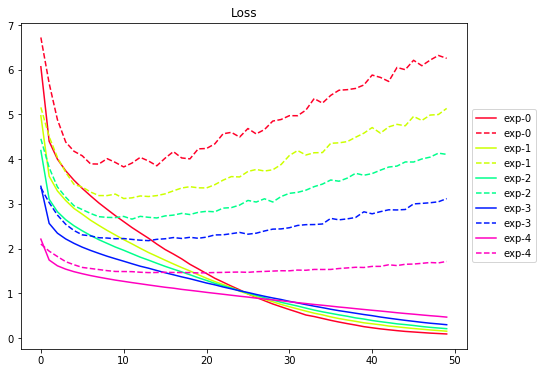

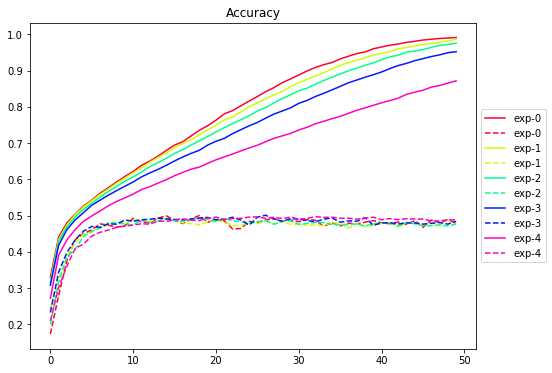

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()